In [2]:
%pylab inline
from sklearn.neural_network import MLPRegressor
import bilby
import redback
import pandas as pd
from bilby.core.prior import Constraint, PriorDict, Uniform
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.transient_models.afterglow_models import tophat, tophat_redback
from sklearn import preprocessing as pre
import scipy.constants as const
from sklearn.model_selection import GridSearchCV, cross_validate
import random
import pickle
from scipy import interpolate

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [94]:
def line(x, m, c, **kwargs):
    return m*x+c

prior = bilby.core.prior.PriorDict()
prior['m'] = bilby.core.prior.Uniform(3, 8, 'm')
prior['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

In [95]:
xs = np.linspace(1, 20, 50)
models = 100
ys = np.zeros((models, len(xs)))
samples = pd.DataFrame(prior.sample(models))

In [96]:
for ii in range(models):
    ys[ii] = line(xs, **samples.iloc[ii].to_dict())
    plt.plot(xs, ys[ii], color='red', alpha=0.05)

In [97]:
X_train = samples.values
y_train = ys
regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train)

In [49]:
y_pred = regr.predict(np.array([4, -1]).reshape(1, -1))
print(y_pred.shape)

(1, 50)


In [48]:
y_true = line(xs, 4, -1)

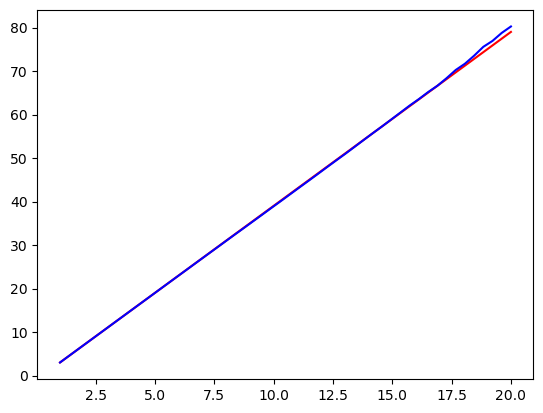

In [50]:
plt.plot(xs, y_true, color='red')
plt.plot(xs, y_pred[0,:], color='blue')

In [2]:
def afterglow(time, redshift,  thv, loge0 , thc, logn0, p, logepse, logepsb, ksin, g0, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', redshift=redshift,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=ksin, g0=g0, frequency= frequency)
    return ag_fluxd


In [3]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,300,300) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    minflux=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=1146839759677006.2)
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        fluxday1= np.interp(1,time,flux)
        minflux.append(fluxday1)
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    #filter on axis results (comment out if needed)
    #constrained_params['onaxis']= 0.05 - parameters['thv']
    #filter lower flux afterglows out for ON AXIS case (comment out if needed)
    #constrained_params['min_flux']= np.array(minflux) - 10e-7
    #filter off axis results (comment out if needed)
    constrained_params['offaxis']= parameters['thv'] - 0.06
    return constrained_params

In [2]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
#priors['onaxis']= Constraint(minimum=0, maximum=0.05)
#priors['min_flux']=Constraint(minimum=0, maximum=10)
priors['offaxis']= Constraint(minimum=0.06, maximum=(np.pi)/2)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000
priors['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)

num=10000
samples=priors.sample(num)
afterglow_data=pd.DataFrame.from_dict(samples)

NameError: name 'afterglow_constraints' is not defined

In [269]:
time = np.linspace(0.1, 300, 600) #xs
yvals = np.zeros((num, len(time)))  #ys

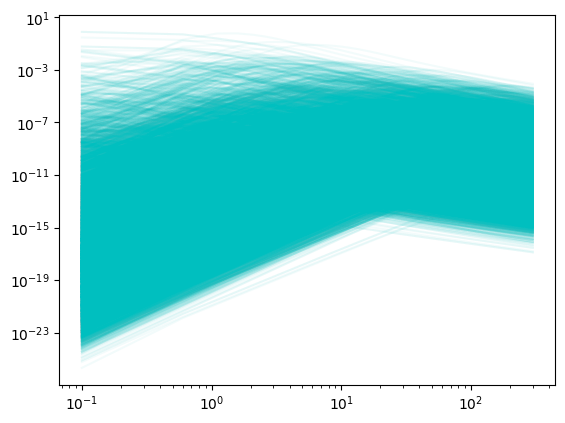

In [270]:
ax= plt.subplot()

for i in range(num):
    yvals[i]= afterglow(time, **afterglow_data.iloc[i])
    ax.loglog(time, yvals[i], color='c', alpha=0.05)
plt.show()

In [290]:
X = afterglow_data.values
Y = yvals
regr = MLPRegressor(random_state=7, max_iter=7000, hidden_layer_sizes=(200,),activation='logistic',solver='sgd', learning_rate='adaptive').fit(X, Y)

In [291]:
params=np.array([0.01, 0.5, 50.0 , 0.02, 1, 2.13,-1.25, -2.5, 1, 1000, 4e14])
prediction = regr.predict(params.reshape(1,-1))
prediction.shape

(1, 600)

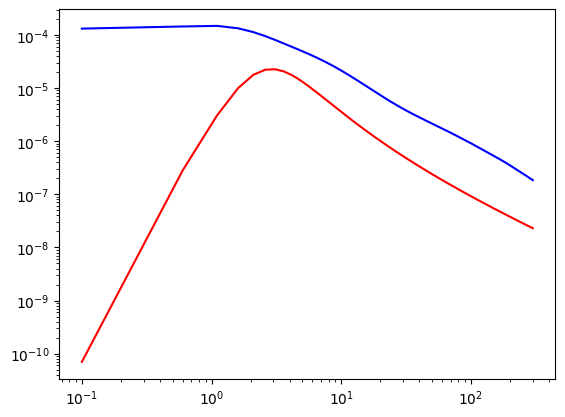

In [292]:
test_params= dict(redshift=0.01,  thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
     frequency= 4e14)
true_value= afterglow(time, **test_params)
ax1=plt.subplot()
ax1.loglog(time, true_value, color='red')
ax1.loglog(time, prediction[0,:], color='blue')#, ls='None', marker='x')
plt.show()

In [3]:
def tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat(time=time, output_format='flux_density', redshift=0.01,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=1, g0=g0, frequency= frequency)
    return flux

In [1]:

def new_tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat_redback(time=time, output_format='flux_density', redshift=0.01, steps=1000, thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, xiN=1, g0=g0, frequency= frequency)
    return flux

In [12]:
general_priors= redback.priors.get_priors(model='tophat_redback')
#general_priors['frequency']= Uniform(minimum=1e13, maximum=2e15, name='frequency', latex_label='$frequency$', unit=None, boundary=None)
frequency=[]
"""
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),10000))
    frequency.extend(rand_samples)
"""
frequency=np.ones(10000)*3.45e14
random.shuffle(frequency)
num=10000
tnum=1000
samples=general_priors.sample(num)
samples['frequency']=frequency
tophat_data=pd.DataFrame.from_dict(samples)
unprocessed= pd.DataFrame.from_dict(samples)
tophat_data.drop('redshift', axis=1,inplace=True)
tophat_data.drop('xiN', axis=1,inplace=True)
unprocessed.drop('redshift', axis=1,inplace=True)
unprocessed.drop('xiN', axis=1,inplace=True)

tophat_data['thv']=np.log10(tophat_data['thv'])
tophat_data['thc']=np.log10(tophat_data['thc'])
tophat_data['g0']=np.log10(tophat_data['g0'])
tophat_data['frequency']=np.log10(tophat_data['frequency'])

min(unprocessed['frequency'])

345000000000000.0

In [13]:
tophat_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,0.086591,50.955687,-1.333852,1.755815,2.333456,-4.797587,-0.158102,3.039636,14.537819
1,0.179833,51.403834,-1.045982,-1.142548,2.675037,-1.014604,-1.517388,3.258801,14.537819
2,-0.257829,44.309746,-1.218780,-3.856583,2.591953,-2.813353,-0.619527,3.264514,14.537819
3,0.153122,49.184696,-1.306557,-1.227262,2.172978,-4.704169,-1.905943,2.841403,14.537819
4,0.043735,53.726094,-1.879590,-3.050241,2.764401,-4.040364,-1.791331,2.883570,14.537819
...,...,...,...,...,...,...,...,...,...
9995,0.153766,52.276302,-1.762236,0.388943,2.061816,-1.472824,-1.433491,3.183528,14.537819
9996,-0.083488,46.464124,-1.789528,-3.170398,2.109459,-4.102287,-4.458078,2.981767,14.537819
9997,-0.046928,47.863865,-1.554949,-1.404896,2.277148,-4.039696,-4.990257,2.818195,14.537819
9998,0.101652,53.540732,-1.309848,-3.710783,2.254224,-3.748299,-2.693261,2.918713,14.537819


In [3]:
def axis_spec(parameters):
    constrained_params= parameters.copy()

    #thv-thc for off axis, thc-thv for on axis
    constrained_params['alignment']=  parameters['thc']-parameters['thv']
    return constrained_params

In [4]:
priors = PriorDict(conversion_function=axis_spec)
priors['alignment']= Constraint(minimum=0, maximum=1.57)
priors.update(redback.priors.get_priors(model='tophat_redback'))
priors.pop('redshift')
priors.pop('xiN')
priors

{'alignment': Constraint(minimum=0, maximum=1.57, name=None, latex_label=None, unit=None),
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}~\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}~\\epsilon_{B}$', unit=None, b

In [6]:
onax_samples=priors.sample(108000)
frequency=[]
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),12000))
    frequency.extend(rand_samples)
random.shuffle(frequency)
onax_samples['frequency']=frequency
onax_data=pd.DataFrame.from_dict(onax_samples)
onax_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,0.075655,51.023757,0.077116,0.544842,2.114128,-1.309170,-4.183533,1185.130295,68498961800
1,0.025271,46.871813,0.074566,-4.878133,2.551606,-3.033867,-1.545993,1745.164224,27126650295
2,0.079906,47.473028,0.099515,1.573548,2.899874,-0.319392,-2.088632,1990.700167,15896540177
3,0.063456,51.707504,0.073241,-3.067940,2.115858,-2.035245,-1.662622,1393.079841,3893498146674294
4,0.082252,50.963151,0.091654,1.704766,2.845617,-2.796725,-2.109110,1892.359494,1246161323426020
...,...,...,...,...,...,...,...,...,...
107995,0.071499,44.157696,0.072606,0.689452,2.306322,-2.161411,-4.439584,1219.108476,33152450875
107996,0.090980,53.102981,0.095712,0.695997,2.040405,-1.512992,-3.562801,909.324343,894844911200450549
107997,0.060833,44.213250,0.088436,-0.339070,2.169259,-2.832042,-0.681151,1117.305623,30710671786973033
107998,0.039491,48.426163,0.066474,-1.803342,2.238778,-3.962953,-0.552242,1112.316182,6773510402


In [5]:
12000*9

108000

In [87]:
offax_samples=priors.sample(135000)
frequency=[]
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),15000))
    frequency.extend(rand_samples)
random.shuffle(frequency)
offax_samples['frequency']=frequency
offax_data=pd.DataFrame.from_dict(offax_samples)
offax_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,1.526491,53.345660,0.082901,-2.807621,2.873013,-4.519515,-0.872390,349.204004,650063890992
1,1.044682,44.084439,0.041808,-4.863767,2.289062,-0.283317,-2.469083,380.139861,9923696066742859
2,1.059741,53.219942,0.087371,-1.298807,2.797547,-0.798341,-2.300985,1996.208386,357872136616
3,0.510331,52.559011,0.064356,-3.484722,2.892209,-2.573523,-3.325004,175.074512,73198882592429166
4,0.772435,45.372875,0.086676,-0.481821,2.328785,-1.166099,-0.951618,452.552448,3935440648769
...,...,...,...,...,...,...,...,...,...
134995,0.626390,49.664564,0.038057,0.701868,2.044305,-1.288022,-0.339232,1785.337894,104228384879
134996,1.395440,45.378883,0.035432,-3.004313,2.990334,-4.222943,-0.691517,635.307087,29406794572140134
134997,0.893049,45.829665,0.067977,-3.996295,2.527949,-3.770190,-4.755948,1401.030544,868948973246845
134998,0.197383,51.556124,0.088866,0.762625,2.740482,-3.202255,-4.152997,1903.321127,67493338116


In [86]:
15000*9

135000

In [3]:
#unprocessed= pd.concat([onax_data,offax_data], ignore_index=True)
#unprocessed= unprocessed.sample(frac=1).reset_index(drop=True)
#unprocessed_on=pd.read_csv('/home/wfw23/Mphys_proj/onax_data.csv')
unprocessed=pd.read_csv('/home/wfw23/Mphys_proj/onax_data.csv')
#unprocessed=pd.concat([unprocessed_on,unprocessed_off], axis=0)
#unprocessed=unprocessed.sample(frac=1)
tophat_data= unprocessed.copy()
tophat_data['thv']=np.log10(tophat_data['thv'])
tophat_data['thc']=np.log10(tophat_data['thc'])
tophat_data['g0']=np.log10(tophat_data['g0'])
tophat_data['frequency']=np.log10(tophat_data['frequency'])

In [4]:
unprocessed

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,0.075655,51.023757,0.077116,0.544842,2.114128,-1.309170,-4.183533,1185.130295,68498961800
1,0.025271,46.871813,0.074566,-4.878133,2.551606,-3.033867,-1.545993,1745.164224,27126650295
2,0.079906,47.473028,0.099515,1.573548,2.899874,-0.319392,-2.088632,1990.700167,15896540177
3,0.063456,51.707504,0.073241,-3.067940,2.115858,-2.035245,-1.662622,1393.079841,3893498146674294
4,0.082252,50.963151,0.091654,1.704766,2.845617,-2.796725,-2.109110,1892.359494,1246161323426020
...,...,...,...,...,...,...,...,...,...
107995,0.071499,44.157696,0.072606,0.689452,2.306322,-2.161411,-4.439584,1219.108476,33152450875
107996,0.090980,53.102981,0.095712,0.695997,2.040405,-1.512992,-3.562801,909.324343,894844911200450549
107997,0.060833,44.213250,0.088436,-0.339070,2.169259,-2.832042,-0.681151,1117.305623,30710671786973033
107998,0.039491,48.426163,0.066474,-1.803342,2.238778,-3.962953,-0.552242,1112.316182,6773510402


In [9]:
unprocessed.iloc[0]

thv          7.372709e-01
loge0        5.093545e+01
thc          2.091916e-02
logn0       -1.316681e+00
p            2.588356e+00
logepse     -3.485966e+00
logepsb     -2.875153e+00
g0           6.780694e+02
frequency    4.028468e+10
Name: 77382, dtype: float64

In [7]:
tophat_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
77382,-0.132373,50.935449,-1.679456,-1.316681,2.588356,-3.485966,-2.875153,2.831274,10.605140
86778,-0.073876,46.834913,-1.175191,-2.475098,2.412843,-0.095128,-1.652080,3.249863,13.905582
22101,0.013110,49.499331,-1.048236,-2.543488,2.700246,-4.673927,-2.312790,2.923704,11.420905
90144,0.161596,52.529891,-1.015525,1.392055,2.253658,-3.230920,-0.732667,2.480106,12.142904
99282,-1.498622,49.596149,-1.418843,0.598244,2.917920,-2.049173,-2.924171,2.752399,17.425322
...,...,...,...,...,...,...,...,...,...
11264,-0.057002,46.432629,-1.124825,1.580264,2.138614,-3.578754,-1.574827,3.117515,10.957592
131445,0.151024,48.358705,-1.264636,-0.525126,2.577499,-3.380604,-1.529232,3.109642,11.638577
34205,-1.138245,51.301157,-1.001150,-1.321804,2.891194,-0.094304,-0.080848,3.138573,9.925811
91115,-0.105616,49.858063,-1.105258,-3.186543,2.757192,-0.154243,-4.275639,3.136402,9.677544


In [7]:
onax_data.to_csv('onax_data.csv', index=False)

In [84]:
10**2.94/86400

0.010080597105973154

In [4]:
num=108000
tnum=3000 #?
training = tophat_data.iloc[:(num-tnum)]
testing = tophat_data.iloc[(num-tnum):]


In [6]:
training

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
0,-1.121161,51.023757,-1.112858,0.544842,2.114128,-1.309170,-4.183533,3.073766,10.835684
1,-1.597369,46.871813,-1.127461,-4.878133,2.551606,-3.033867,-1.545993,3.241836,10.433396
2,-1.097419,47.473028,-1.002113,1.573548,2.899874,-0.319392,-2.088632,3.299006,10.201303
3,-1.197530,51.707504,-1.135244,-3.067940,2.115858,-2.035245,-1.662622,3.143976,15.590340
4,-1.084852,50.963151,-1.037846,1.704766,2.845617,-2.796725,-2.109110,3.277004,15.095574
...,...,...,...,...,...,...,...,...,...
104995,-1.356130,45.044899,-1.153133,-3.427525,2.178387,-0.610387,-3.169708,2.976624,16.316689
104996,-1.500233,46.520159,-1.329155,-1.165161,2.968143,-1.205202,-0.768707,2.400292,15.691382
104997,-1.199113,49.305638,-1.125732,-4.015840,2.475235,-3.957800,-1.678121,2.342599,16.641127
104998,-1.203848,46.455740,-1.190484,-2.419337,2.662047,-4.477507,-3.594439,2.552864,10.891730


In [6]:
#original
time = np.linspace(0.1, 1, 10)
time=np.insert(time,10,np.linspace(1.2,10,20))
time=np.insert(time,30,np.linspace(12,300,70))

In [83]:
#lower res
time = np.linspace(0.1, 1, 5)
time=np.insert(time,5,np.linspace(1.2,10,15))
time=np.insert(time,20,np.linspace(12,300,40))

In [107]:
#highres1
time2= np.linspace(0.1,1,10)
time2=np.insert(time2,10,np.linspace(1.2,10,20))
time2=np.insert(time2,30,np.linspace(12,300,170))

In [73]:
time5= np.linspace(0.1,1,5)
time5=np.insert(time3,5,np.linspace(1.2,10,15))
time5=np.insert(time3,20,np.linspace(12,50,30))
time5=np.insert(time3,50,np.linspace(52,300,50))


In [85]:
#bad result
time3= np.linspace(0.1,1,3)
time3=np.insert(time3,3,np.linspace(1.2,10,12))
time3=np.insert(time3,15,np.linspace(12,100,75))
time3=np.insert(time3,90,np.linspace(100,300,110))

In [97]:
#highres_tophat_redback2
time4= np.linspace(0.1,1,5)
time4=np.insert(time4,5,np.linspace(1.2,10,15))
time4=np.insert(time4,20,np.linspace(12,100,50))
time4=np.insert(time4,70,np.linspace(102,300,80))

In [5]:
logtime= np.logspace(2.94,7.41,100)/86400

In [ ]:
#time = np.linspace(0.1, 300, 150) #xs
ys = np.zeros((num-tnum, len(logtime)))  #ys

ax= plt.subplot()

for i in range(num-tnum):
    ys[i]= new_tophat_func(logtime, **unprocessed.iloc[i])
    ax.loglog(logtime, ys[i], color='c', alpha=0.05)
plt.show()

In [6]:
#on_yvals=np.load('onax_yvals.npy')
yvals=np.load('onax_yvals.npy')
#yvals=np.concatenate((on_yvals,off_yvals))
#yvals

In [7]:
ys=yvals[training.index]
ys.shape

(105000, 100)

In [8]:
testys=yvals[testing.index]
testys.shape

(3000, 100)

In [9]:
scalerx = pre.StandardScaler()
scalery = pre.StandardScaler()
Y_train = scalery.fit_transform(np.log(ys))
X_train = scalerx.fit_transform(training.values)
X_test= scalerx.transform(testing.values)

#params=np.array([0.5, 50.0 , 0.02, 1, 2.13,-1.25,-2.5, 1000])
#prediction = regr.predict(params.reshape(1,-1))


In [10]:
regressor = MLPRegressor(random_state=7, max_iter=1000, hidden_layer_sizes=(800), activation='relu',solver='adam',learning_rate='adaptive',
                   learning_rate_init=1e-3, batch_size=128, early_stopping=True, alpha=0.01).fit(X_train, Y_train)

In [11]:
regressor.best_validation_score_

0.9996765502116134

In [34]:
mlp = MLPRegressor(random_state=7, max_iter=1000, hidden_layer_sizes=(250,250,250), activation='relu',solver='adam',learning_rate='adaptive',
                   learning_rate_init=1e-3, batch_size=128, early_stopping=True, alpha=0.0005)
scores=cross_validate(mlp, X_train, Y_train, cv=3, n_jobs=-1, pre_dispatch=3, verbose=3, return_train_score=True)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished


{'fit_time': array([192.45654011, 178.40416288, 159.74724674]),
 'score_time': array([1.50727654, 0.64110637, 0.93910384]),
 'test_score': array([0.99969137, 0.99960203, 0.99960548]),
 'train_score': array([0.99972159, 0.99961753, 0.99964003])}

In [12]:
prediction = regressor.predict(X_test)
prediction = np.exp(scalery.inverse_transform(prediction))


testys= np.zeros((tnum, len(logtime)))
for i in range(tnum):
    testys[i]= new_tophat_func(logtime, **unprocessed.iloc[(num-tnum)+i])


In [13]:
X= scalerx.transform(testing.values)
Y= scalery.transform(np.log(testys))
regressor.score(X,Y)

0.9997280643566255

time original
0.9992 for 1000x1

time lower res
0.9991

time4 100 test samples
0.9987 for 300x3 
0.9992 for 500x2

time5 100 test samples
0.9991 for 500x2

time3 1000 test samples
0.9986 for 500x2

logtime (100pts) 1000 test samples
0.9984 for 500x2
0.9990 for 500x3
0.9991 for 1000x1

logtime(50pts) 1000 test samples
0.9992 for 500x2
0.9988 for 500x1
0.9988 for 300x3
0.9990 for 300x2
0.9992 for 800x1 -smoother
0.9993 for 800x2
0.9992 for 1000x1

final 5000 test 0.99888

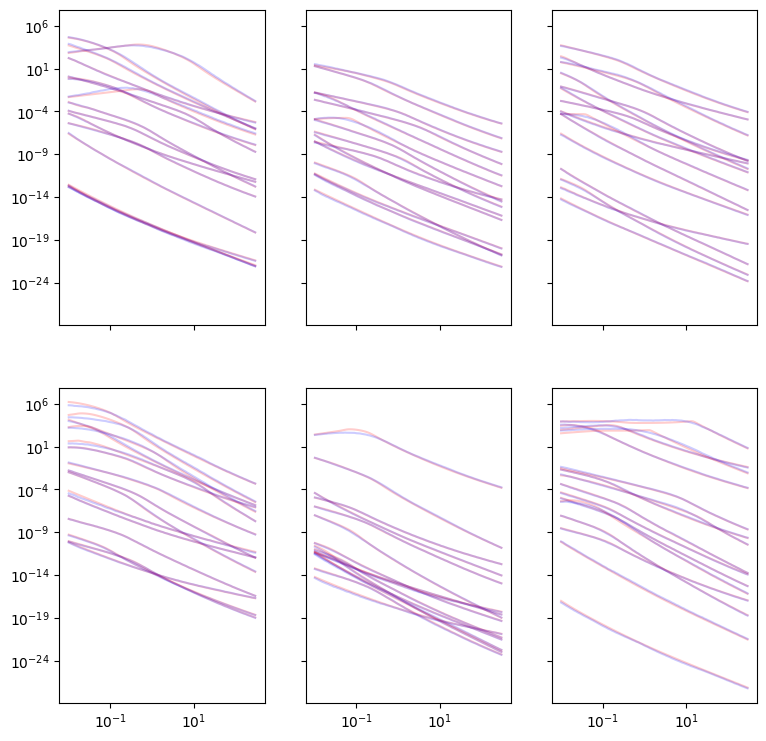

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,9), sharex=True, sharey=True)
#time = np.linspace(0.1, 300, 150) #xs
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)

for i in range(15): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[0,0].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[0,0].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(15,30): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[0,1].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[0,1].loglog(logtime, prediction[i], color='blue', alpha=0.2)

for i in range(30,45): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[1,0].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[1,0].loglog(logtime, prediction[i], color='blue', alpha=0.2)
    #print(unprocessed.iloc[i+(num-tnum)])

for i in range(45,60): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[1,1].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[1,1].loglog(logtime, prediction[i], color='blue', alpha=0.2)
    #print(unprocessed.iloc[i+(num-tnum)])
for i in range(60,75): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[0,2].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[0,2].loglog(logtime, prediction[i], color='blue', alpha=0.2)
for i in range(75,90): 
    true_value= new_tophat_func(logtime, **unprocessed.iloc[i+(num-tnum)])
    ax[1,2].loglog(logtime, true_value, color='red', alpha=0.2)
    ax[1,2].loglog(logtime, prediction[i], color='blue', alpha=0.2)
'''
for i in range(3):
    true_value= new_tophat_func(logtime, **unprocessed.iloc[24+i+(num-tnum)])
    ax[1,0].loglog(logtime, true_value, color='green', alpha=0.5)
#plt.savefig("emulation_final.png", dpi='figure')
'''
plt.show()

In [67]:
for i in range(15,30): 
    print(unprocessed.iloc[i+(num-tnum)])

thv          5.825663e-01
loge0        5.215277e+01
thc          2.316964e-02
logn0       -5.976138e-01
p            2.589388e+00
logepse     -4.475520e+00
logepsb     -2.357292e+00
g0           1.089819e+03
frequency    8.571321e+17
Name: 111214, dtype: float64
thv          3.679991e-01
loge0        4.495710e+01
thc          9.150074e-02
logn0       -2.056537e+00
p            2.830807e+00
logepse     -2.264828e+00
logepsb     -2.275630e+00
g0           1.054068e+03
frequency    8.588386e+11
Name: 111215, dtype: float64
thv          1.271023e-01
loge0        5.383523e+01
thc          5.698384e-02
logn0       -1.090324e+00
p            2.808120e+00
logepse     -1.872079e+00
logepsb     -1.266278e+00
g0           1.867670e+03
frequency    1.230797e+12
Name: 111216, dtype: float64
thv          1.077694e+00
loge0        4.594557e+01
thc          3.688752e-02
logn0       -4.753839e+00
p            2.863482e+00
logepse     -2.526812e-01
logepsb     -1.696093e+00
g0           3.516818e+02
fre

In [18]:
unprocessed.iloc[35+(num-tnum)]

thv          5.764959e-01
loge0        5.096447e+01
thc          5.946973e-02
logn0       -4.078088e+00
p            2.177178e+00
logepse     -7.724948e-02
logepsb     -5.757993e-01
g0           1.908266e+03
frequency    3.570358e+09
Name: 112035, dtype: float64

In [30]:
unprocessed.iloc[41+(num-tnum)]

thv          1.287853e+00
loge0        4.890727e+01
thc          3.559955e-02
logn0       -1.635965e+00
p            2.867339e+00
logepse     -3.026419e-02
logepsb     -2.426275e+00
g0           1.382067e+03
frequency    3.234376e+09
Name: 112041, dtype: float64

In [11]:
with open("tophat.pkl", "wb") as f:
    pickle.dump(regr, f)

In [15]:
with open("onax_redback_01.pkl", "wb") as file:
    pickle.dump(regressor, file)

In [16]:
with open("onax_scalery_01.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("onax_scalerx_01.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)

In [33]:
with open("new_scalery.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("new_scalerx.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)

In [69]:
params={}
params['thv']= np.log10(0.07)
params['loge0'] = 51.5
params['thc'] = np.log10(0.09)
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['g0'] = np.log10(1000)
params['frequency']=np.log10(3.45e14)
test=np.fromiter(params.values(),dtype=float).reshape(1,-1)

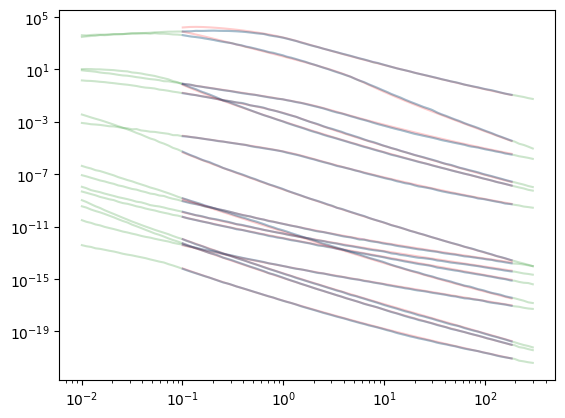

In [14]:
#time=np.linspace(0.1,300,150)
'''
with open("tophat_redback.pkl", "rb") as f:
    model = pickle.load(f)
with open("scalery_redback.pkl", "rb") as sy:
    scalery = pickle.load(sy)
with open("scalerx_redback.pkl", "rb") as sx:
    scalerx = pickle.load(sx) 
'''
xtests= scalerx.transform(testing.values)
prediction= regressor.predict(xtests)
prediction = np.exp(scalery.inverse_transform(prediction))
#print(model.score(xtests,scalery.transform(np.log10(ys))))
afterglow = interpolate.interp1d(logtime, prediction, kind='linear')
new_time= np.linspace(0.11,40,200)
new_time= np.logspace(3.9,7.2,50)/86400

fluxd= afterglow(new_time)

ax=plt.subplot()
for i in range(15,30):
    true_value= new_tophat_func(new_time, **unprocessed.iloc[i+(num-tnum)])
    #print(unprocessed.iloc[i+(num-tnum)])
    ax.loglog(new_time, true_value, color='red', alpha=0.2)#, marker='o', markersize=2)#actual function with 'interpolated time'
    ax.loglog(new_time, fluxd[i], color='blue', alpha=0.2)#, marker='o', markersize=2) #predicted by emulator with interpolation
    ax.loglog(logtime, prediction[i], color='green', alpha=0.2)#, marker='o', markersize=2) #prediction emulator no interpolation
#true_value= new_tophat_func(new_time, **unprocessed.iloc[19+(num-tnum)])
#ax.loglog(new_time, true_value, color='purple', alpha=0.2)
plt.show()

In [154]:
unprocessed.iloc[19+num-tnum]

thv          1.473825e-01
loge0        5.260471e+01
thc          7.948577e-02
logn0       -7.455978e-01
p            2.142358e+00
logepse     -1.833241e+00
logepsb     -3.297658e+00
g0           3.347162e+02
frequency    3.450000e+14
Name: 9019, dtype: float64

In [147]:
true_value= new_tophat_func(new_time, **unprocessed.iloc[15+(num-tnum)])
ax.loglog(new_time, true_value, color='purple', alpha=0.2)
plt.show()

In [65]:
len(prediction)

1000

In [21]:
np.log10(300*86400)

7.413634997198556

In [16]:
new_time= np.logspace(0.1,1.5,50)/86400
print(new_time)

[1.45708960e-05 1.55617232e-05 1.66199271e-05 1.77500893e-05
 1.89571031e-05 2.02461943e-05 2.16229443e-05 2.30933138e-05
 2.46636692e-05 2.63408093e-05 2.81319958e-05 3.00449836e-05
 3.20880555e-05 3.42700572e-05 3.66004359e-05 3.90892814e-05
 4.17473694e-05 4.45862086e-05 4.76180900e-05 5.08561407e-05
 5.43143803e-05 5.80077817e-05 6.19523359e-05 6.61651215e-05
 7.06643784e-05 7.54695867e-05 8.06015513e-05 8.60824916e-05
 9.19361383e-05 9.81878354e-05 1.04864651e-04 1.11995492e-04
 1.19611234e-04 1.27744850e-04 1.36431555e-04 1.45708960e-04
 1.55617232e-04 1.66199271e-04 1.77500893e-04 1.89571031e-04
 2.02461943e-04 2.16229443e-04 2.30933138e-04 2.46636692e-04
 2.63408093e-04 2.81319958e-04 3.00449836e-04 3.20880555e-04
 3.42700572e-04 3.66004359e-04]


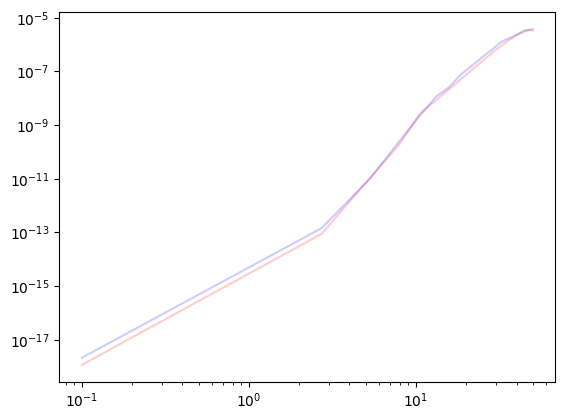

In [8]:
new_time= np.linspace(0.1,50,20)
fluxd= afterglow(new_time)

ax=plt.subplot()
for i in range(1,2):
    true_value= new_tophat_func(new_time, **unprocessed.iloc[i+(num-tnum)])
    ax.loglog(new_time, true_value, color='red', alpha=0.2)
    ax.loglog(new_time, fluxd[i], color='blue', alpha=0.2)
plt.show()

In [116]:
prediction.shape

(100, 100)

In [ ]:
for i in range(10):
    plt.plot(time, ys)
    plt.plot(time, new_tophat_func(time,xtests[i]))

In [63]:
prediction.shape

(100, 100)

In [7]:
fluxd.shape

(100, 50)

In [15]:
prediction.shape

(100, 150)

In [21]:
xtests.shape

(100, 9)

In [38]:
unprocessed.iloc[2+(num-tnum)]

thv          1.122384e+00
loge0        5.159928e+01
thc          1.529868e-02
logn0       -1.734760e+00
p            2.967152e+00
logepse     -3.121768e-01
logepsb     -6.179132e-01
g0           5.168700e+02
frequency    6.516236e+14
Name: 79902, dtype: float64

In [39]:
unprocessed.iloc[11+(num-tnum)]

thv          6.543900e-02
loge0        4.983819e+01
thc          2.080898e-02
logn0       -3.140924e+00
p            2.251693e+00
logepse     -3.730114e+00
logepsb     -3.953608e+00
g0           2.132696e+02
frequency    3.087617e+17
Name: 79911, dtype: float64

In [75]:
unprocessed['frequency'].iloc[num-tnum:].values

array([1.00656140e+14, 1.06020086e+15, 1.29688986e+15, 1.12992999e+15,
       4.47437220e+14, 1.93297609e+15, 7.56629244e+14, 9.70446701e+14,
       1.17409372e+15, 1.41467503e+14, 4.49154818e+13, 7.81176125e+14,
       1.66962403e+15, 1.04042828e+15, 2.82502902e+14, 1.59135245e+15,
       1.80573842e+15, 1.26905363e+15, 1.26559804e+15, 1.52777522e+15,
       1.19898263e+15, 6.07214871e+14, 6.64438092e+14, 1.87507081e+15,
       2.52054190e+13, 3.56368518e+14, 1.29395306e+15, 4.69968628e+14,
       1.28224333e+15, 6.25654261e+14, 1.03705093e+14, 9.67024739e+14,
       1.24829321e+15, 1.94731382e+14, 1.24752724e+15, 7.51019582e+14,
       2.12234999e+14, 1.98934120e+15, 1.62828601e+15, 1.69866155e+14,
       4.20091907e+13, 1.41625790e+15, 1.71859143e+15, 1.50969322e+15,
       1.56926946e+15, 1.16343556e+15, 4.51808285e+14, 1.97380320e+14,
       3.56269372e+14, 1.60267180e+15, 9.03281048e+14, 1.46055184e+15,
       1.54683553e+15, 1.28757302e+15, 1.33752192e+14, 4.20890107e+14,
      

In [73]:
print(regr.n_iter_, regr.best_loss_)

73 0.005612029467075825


In [11]:
print(regr.n_iter_, regr.best_loss_)

38 0.0013669637969929973


In [14]:
print(regr.n_iter_, regr.best_loss_, regr.t_)

10 0.0014232664780402901 999000


In [12]:
param_grid={}
param_grid['hidden_layer_sizes']=[(100,100,100), (700),(200,200)]
param_grid['alpha']=[0.0001]
#param_grid['activation']=['relu']
#param_grid['solver']=['adam','sgd']
#param_grid['batch_size']=[64,128]
#param_grid['learning_rate_init']=[0.001]

In [13]:
mlp = MLPRegressor(random_state=7, max_iter=1000, learning_rate_init=0.001, batch_size=128,activation='relu',solver='adam',early_stopping=True)
tuner = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, verbose=3, pre_dispatch=3, return_train_score=True)
tuner.fit(X_train,Y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100);, score=(train=1.000, test=1.000) total time= 1.3min
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100);, score=(train=1.000, test=1.000) total time= 1.5min
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100);, score=(train=1.000, test=1.000) total time= 1.5min
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=700;, score=(train=1.000, test=1.000) total time= 2.1min
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=700;, score=(train=1.000, test=1.000) total time= 2.4min


GridSearchCV(cv=3,
             estimator=MLPRegressor(batch_size=128, early_stopping=True,
                                    max_iter=1000, random_state=7),
             n_jobs=-1,
             param_grid={'alpha': [0.0001],
                         'hidden_layer_sizes': [(100, 100, 100), 700,
                                                (200, 200)]},
             pre_dispatch=3, return_train_score=True, verbose=3)

[CV 3/3] END alpha=0.0001, hidden_layer_sizes=700;, score=(train=1.000, test=1.000) total time= 2.9min


In [17]:
tuner.best_score_

0.999681940473374

In [18]:
tuner.best_params_

{'alpha': 0.0001, 'hidden_layer_sizes': (400, 400)}

In [14]:
#on ax
tuner.cv_results_

{'mean_fit_time': array([ 84.40760008, 142.87259865, 127.71824098]),
 'std_fit_time': array([ 6.91203508, 20.66519333, 22.77281015]),
 'mean_score_time': array([1.48502938, 3.41483943, 0.90936073]),
 'std_score_time': array([0.36141552, 0.27801358, 0.02533741]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(100, 100, 100), 700, (200, 200)],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100)},
  {'alpha': 0.0001, 'hidden_layer_sizes': 700},
  {'alpha': 0.0001, 'hidden_layer_sizes': (200, 200)}],
 'split0_test_score': array([0.99968874, 0.99970319, 0.99983894]),
 'split1_test_score': array([0.99978282, 0.99971623, 0.99981277]),
 'split2_test_score': array([0.99975777, 0.99976139, 0.99978235]),
 'mean_test_score': array([0.99

[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(200, 200);, score=(train=1.000, test=1.000) total time= 2.0min
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(200, 200);, score=(train=1.000, test=1.000) total time= 2.7min
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(200, 200);, score=(train=1.000, test=1.000) total time= 1.8min


In [19]:
#off ax
tuner.cv_results_

{'mean_fit_time': array([320.42650851, 147.88316846, 200.55598203, 123.42010403,
        264.44954729, 175.62216139, 191.20988917, 107.2963117 ]),
 'std_fit_time': array([73.40048355,  9.25607758, 23.03774888, 31.17044323, 64.32190299,
        13.32300999, 12.43722457, 10.34565238]),
 'mean_score_time': array([4.27991088, 0.89820425, 1.11937666, 0.92109156, 2.60941958,
        1.27888004, 1.12796903, 0.52028306]),
 'std_score_time': array([1.93013258, 0.23318564, 0.38038599, 0.56577663, 0.76579962,
        0.17354527, 0.4864493 , 0.11803242]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.0001, 0.0001, 0.0001, 0.0001],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(400, 400), 800, (250, 250, 250),
                    (100, 100, 100, 100, 100), (400, 400), 800,
                    (250, 250, 250), (100, 100, 100, 100, 100)],
              mask

In [76]:
def power(frequency, g0, logepsb, logn0):
    me= const.m_e
    mp= const.m_p
    c= const.c
    sigma = const.sigma
    q=const.e
    n0= 10**(logn0)
    epsb= 10**(logepsb)
    constant = (me*(c**3)*sigma*((32*np.pi*mp)**0.5))/(3*q)

    pow= constant*(g0**2)*((epsb*n0)**0.5)*frequency*10e7 #power in ergs
    return pow

In [77]:
pprior = bilby.core.prior.PriorDict()
pprior['g0'] = bilby.core.prior.Uniform(100, 2000, 'g0')
pprior['logepsb'] = bilby.core.prior.Uniform(-5, 0, 'c')
pprior['logn0']=bilby.core.prior.Uniform(-5,2,'logn0')
pprior

{'g0': Uniform(minimum=100, maximum=2000, name='g0', latex_label='g0', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='c', latex_label='c', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='logn0', unit=None, boundary=None)}

In [78]:
N= 5000
samples=pprior.sample(N)
power_data=pd.DataFrame.from_dict(samples)
power_data

,g0,logepsb,logn0
0,185.380307,-2.711978,0.601665
1,1423.031101,-4.650265,1.992532
2,394.884171,-0.541732,-1.991962
3,1221.158402,-4.845642,1.404221
4,415.062706,-3.860507,-4.259996
...,...,...,...
4995,944.116862,-2.469384,-2.699051
4996,1360.925225,-1.993366,0.738621
4997,959.389273,-3.519324,1.084934
4998,797.601144,-0.752727,-0.088104


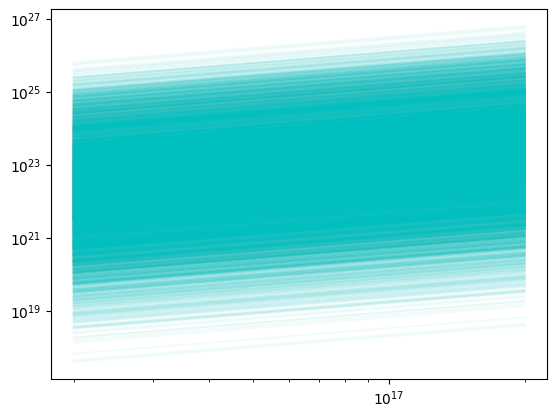

In [188]:
frequency = np.linspace(2e16, 2e17, 500) #xs
y = np.zeros((4900, len(frequency)))  #ys  

ax= plt.subplot()
for i in range(4900):
    y[i]= power(frequency, **power_data.iloc[i])
    ax.loglog(frequency, y[i], color='c', alpha=0.05)
plt.show()

In [196]:
y_train= y
scaler = pre.StandardScaler()
x_train=power_data.iloc[:4900].values
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 

x_test=power_data.iloc[4900:].values
x_test = scaler.transform(x_test)

regress = MLPRegressor(random_state=7, max_iter=2000, hidden_layer_sizes=(100,), activation='tanh',solver='sgd',learning_rate='adaptive', 
                       learning_rate_init=1e-5, batch_size= 16).fit(x_train, y_train)

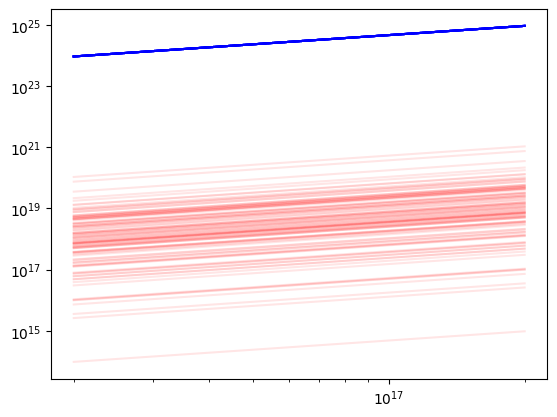

In [197]:
prediction = regress.predict(x_test)
#print(prediction)
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)
ax2=plt.subplot()
for i in range(100): 
    true_value= power(frequency, *x_test[i])
    ax2.loglog(frequency, true_value, color='red', alpha=0.1)
    ax2.loglog(frequency, prediction[i], color='blue', alpha=0.1)# ls='None', marker='x')
    #print(regr.score(testing.values[i].reshape(1,-1),true_value.reshape(1,-1)))
#plt.ylim(10e22,10e25)
plt.show()

In [2]:
from redback.simulate_transients import SimulateGenericTransient
times= np.linspace(0.1,40,100)
num_points=500
noise=0.05

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

model_kwargs = {'output_format':'flux_density', 'frequency':frequencies}

params={}
params['av'] = 0.5
params['loge0'] = 49.5
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['g0'] = 1000
params['thv']= 0.5
params['thc'] = 0.06
params['base_model']='tophat_from_emulator'
    
tophatag =  SimulateGenericTransient(model='extinction_with_afterglow_base_model', parameters=params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)
tophatag.data

[1.952e+14 2.601e+14 3.083e+14 3.454e+14 3.983e+14 4.825e+14 6.273e+14
 8.152e+14 1.141e+15]


,time,frequency,true_output,output,output_error
0,0.100000,2.000000e+17,9.310888e-13,9.655689e-13,4.655444e-14
1,0.100000,3.454000e+14,4.293809e-10,4.552555e-10,2.146905e-11
2,0.503030,5.000000e+09,4.681506e-03,5.094574e-03,2.340753e-04
3,0.503030,2.000000e+17,2.310406e-08,2.361057e-08,1.155203e-09
4,0.906061,2.000000e+17,4.620719e-08,4.410408e-08,2.310360e-09
...,...,...,...,...,...
495,40.000000,5.000000e+09,4.062142e-04,4.473072e-04,2.031071e-05
496,40.000000,6.273000e+14,1.011237e-07,1.007574e-07,5.056185e-09
497,40.000000,1.952000e+14,3.382322e-07,3.651328e-07,1.691161e-08
498,40.000000,2.000000e+17,1.752232e-09,1.769289e-09,8.761158e-11


Meta data does not exist for this event.


[4.10627441e-10 2.61571639e-07 2.28743801e-06 7.09015986e-06
 1.28219993e-05 1.68917857e-05 1.83640209e-05 1.78120805e-05
 1.61653271e-05 1.41510105e-05 1.21482624e-05 1.03507898e-05
 8.81548481e-06 7.53085429e-06 6.46787863e-06 5.59058093e-06
 4.86515860e-06 4.26316000e-06 3.76056890e-06 3.33841656e-06
 2.98151649e-06 2.67765802e-06 2.41742885e-06 2.19312659e-06
 1.99858953e-06 1.82894178e-06 1.68022576e-06 1.54919278e-06
 1.43318434e-06 1.32998131e-06 1.23778634e-06 1.15513330e-06
 1.08077058e-06 1.01361641e-06 9.52732946e-07 8.97382486e-07
 8.46932678e-07 8.00803699e-07 7.58503357e-07 7.19647975e-07
 6.83830318e-07 6.50764561e-07 6.20174260e-07 5.91796907e-07
 5.65453837e-07 5.40912805e-07 5.18044539e-07 4.96674520e-07
 4.76691838e-07 4.57958952e-07 4.40390521e-07 4.23871966e-07
 4.08343170e-07 3.93694850e-07 3.79887463e-07 3.66839550e-07
 3.54502360e-07 3.42823305e-07 3.31748504e-07 3.21250937e-07
 3.11279199e-07 3.01804169e-07 2.92784668e-07 2.84192241e-07
 2.76010037e-07 2.682021

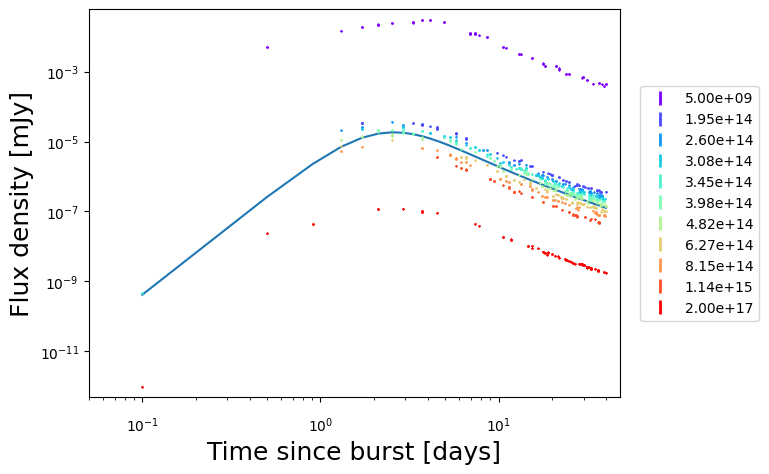

In [3]:
emulator_ag = redback.transient.Afterglow(name='afterglow_emulator', flux_density=tophatag.data['output'].values,
                                      time=tophatag.data['time'].values, data_mode='flux_density',
                                      flux_density_err=tophatag.data['output_error'].values, frequency=tophatag.data['frequency'].values)

ax=emulator_ag.plot_data(show=False)
flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(times, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.5, loge0=49.5 , thc= 0.06, logn0=0.5, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
        output_format='flux_density' , frequency=4.82e14)
print(flux)
ax.loglog(times, flux)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [8]:
model='tophat_from_emulator'
injection_parameters= params
model_kwargs = dict(frequency=emulator_ag.filtered_frequencies, output_format='flux_density')
priors = redback.priors.get_priors('tophat')
priors['redshift']=0.01
priors['ksin']=1
priors

/home/wfw23/anaconda3/envs/myenv/lib/python3.9/encodings/unicode_escape.py:26: DeprecationWarning: invalid escape sequence '\m'
  return codecs.unicode_escape_decode(input, errors, final)


{'redshift': 0.01,
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}~\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}~\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': 1,
 'g0': Uniform(minimum=100, maximum=2000, nam

In [ ]:
emulator_result = redback.fit_model(transient=emulator_ag, model=model, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=priors, sample='rslice', nlive=1000, plot=False, resume=True, injection_parameters=injection_parameters)


16:56 bilby INFO    : Running for label 'GRBafterglow_emulator', output will be saved to 'GRBData/afterglow/flux_density//tophat_from_emulator'
16:56 bilby INFO    : Analysis priors:
16:56 bilby INFO    : thv=Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None)
16:56 bilby INFO    : loge0=Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None)
16:56 bilby INFO    : thc=Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None)
16:56 bilby INFO    : logn0=Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None)
16:56 bilby INFO    : p=Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None)
16:56 bilby INFO    : logepse=Uniform(minimum=-5, maximum=0, nam

1it [00:00, ?it/s]

17:08 bilby INFO    : Written checkpoint file GRBData/afterglow/flux_density//tophat_from_emulator/GRBafterglow_emulator_resume.pickle
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
17:18 bilby INFO    : Written checkpoint file GRBData/afterglow/flux_density//tophat_from_emulator/GRBafterglow_emulator_resume.pickle
17:18 bilby WARNING